---
title: "Escaping the devil's funnel: centered and non-centered priors"
mathjax: True
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Multi-level models are great for improving our estimates. However, the intuitive way these kinds of models are specified (which goes by the [unhelpful](https://media.giphy.com/media/LS4AuDMMDZaUJJcusY/giphy.gif) name "centered" parameterization) can be [notorious](https://media.giphy.com/media/AsDBIwyLjHc9G/giphy.gif) for producing posterior distributions that are difficult to sample using Markov chain Monte Carlo. This is because when parameters (such as the scale variable of one distribution) depends on other parameters, the posterior can have weird shapes. This is the rationale for re-specifying the model into a ["non-centered" parameterization](https://benslack19.github.io/data%20science/statistics/diagnosing-a-model/#me-attempt-4-re-paramaterization).

One does not need a multi-level model to appreciate this concept. In the [divergent transition section of Statistical Rethinking lecture 13 ](https://www.youtube.com/watch?v=n2aJYtuGu54&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13&t=2319s), Dr. McElreath illustrates the centered and non-centered parameterization ideas with what he calls "The Devil's Funnel". A funnel can be seen when plotting $\nu$ and x from the following centered paramaterization (figures shown below).

$$ \nu \sim \text{Normal}(0, 3) $$
$$ x \sim \text{Normal}(0, \text{exp}(\nu)) $$

This is equivalent to 

$$ \nu \sim \text{Normal}(0, 3) $$
$$ z \sim \text{Normal}(0, \text{exp}(\nu)) $$
$$ x = z \times \text{exp}(\nu)) $$

In an online discussion forum, we shared experiences with these kinds of parameterizations since it was around the same time [lecture 13 of Statistical Rethinking](https://www.youtube.com/watch?v=n2aJYtuGu54&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13) was released. In the [divergent transition section](https://www.youtube.com/watch?v=n2aJYtuGu54&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13&t=2319s), I noticed that the centered parameterization had a distribution that looked somewhat multivariate Gaussian. Would there be a difference in sampling efficiency between centered and non-centered parameterizations?

I thought about how manipulating priors might be able to tell us something about sampling between centered parameterization to a non-centered parameterizations. Specifically, I thought there would be points of different models and datasets where the sampling efficiency switches from being better with a centered parameterization to a non-centered parameterization.

Let's see if this really happens! (Spoiler alert: It's not as clear cut as I would have thought.)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
from scipy.special import logit
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Devil's Funnel example

Since I just watched the [divergent transition section](https://www.youtube.com/watch?v=n2aJYtuGu54&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13&t=2319s) of the lecture, I thought my experiments could start here. Dr. McElreath presents "the devil's funnel" as an example to illustrate this. The variables were originally specified like this:

$$ \nu \sim \text{Normal}(0, 3) $$
$$ x \sim \text{Normal}(0, \text{exp}(\nu)) $$

The funnel gets more extreme with higher values for the standard deviation of $\nu$. Since there is no data here, this would be like manipulating priors only. I therefore experimented with different values for the standard deviation (sigma) of $\nu$.

In [730]:
# Generate a list of sigmas for the prior nu
sigmas = np.geomspace(0.025, 1, num=10)

# Create dictionaries for storage
# samples for plotting
traces_C = dict()
traces_NC = dict()

# summary results
summary_C = dict()
summary_NC = dict()

# number of divergences
div_C = dict()
div_NC = dict()

<IPython.core.display.Javascript object>

In [307]:
# Look at sigma values
sigmas

array([0.025     , 0.03766575, 0.05674836, 0.0854988 , 0.12881507,
       0.19407667, 0.29240177, 0.44054134, 0.66373288, 1.        ])

<IPython.core.display.Javascript object>

The following code evaluates each sigma value and uses that to build centered and non-centered models. I'll save the results at the end of each model run and then plot the sampling metrics down below.

In [737]:
for sigma in sigmas:

    # Centered model
    with pm.Model() as mC:
        v = pm.Normal("v", 0.0, sigma)
        x = pm.Normal("x", 0.0, pm.math.exp(v))
        trace_mC = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=False, progressbar=False)
        # Save results
        traces_C[sigma] = trace_mC
        summary_C[sigma] = az.summary(trace_mC)
        div_C[sigma] = trace_mC["diverging"].sum()

    # Non-centered model
    with pm.Model() as mNC:
        v = pm.Normal("v", 0.0, sigma)
        z = pm.Normal("z", 0.0, 1.0)
        # transformed variable
        x = pm.Deterministic("x", z*np.exp(v))
        trace_mNC = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=False, progressbar=False)

        # Save results
        traces_NC[sigma] = trace_mNC
        summary_NC[sigma] = az.summary(trace_mNC)
        div_NC[sigma]= trace_mNC["diverging"].sum()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, v]
INFO:pymc3:NUTS: [x, v]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, v]
INFO:pymc3:NUTS: [z, v]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw it

<IPython.core.display.Javascript object>

## Exploration of the joint distribution

<ipython-input-748-9c60ee011cae>:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


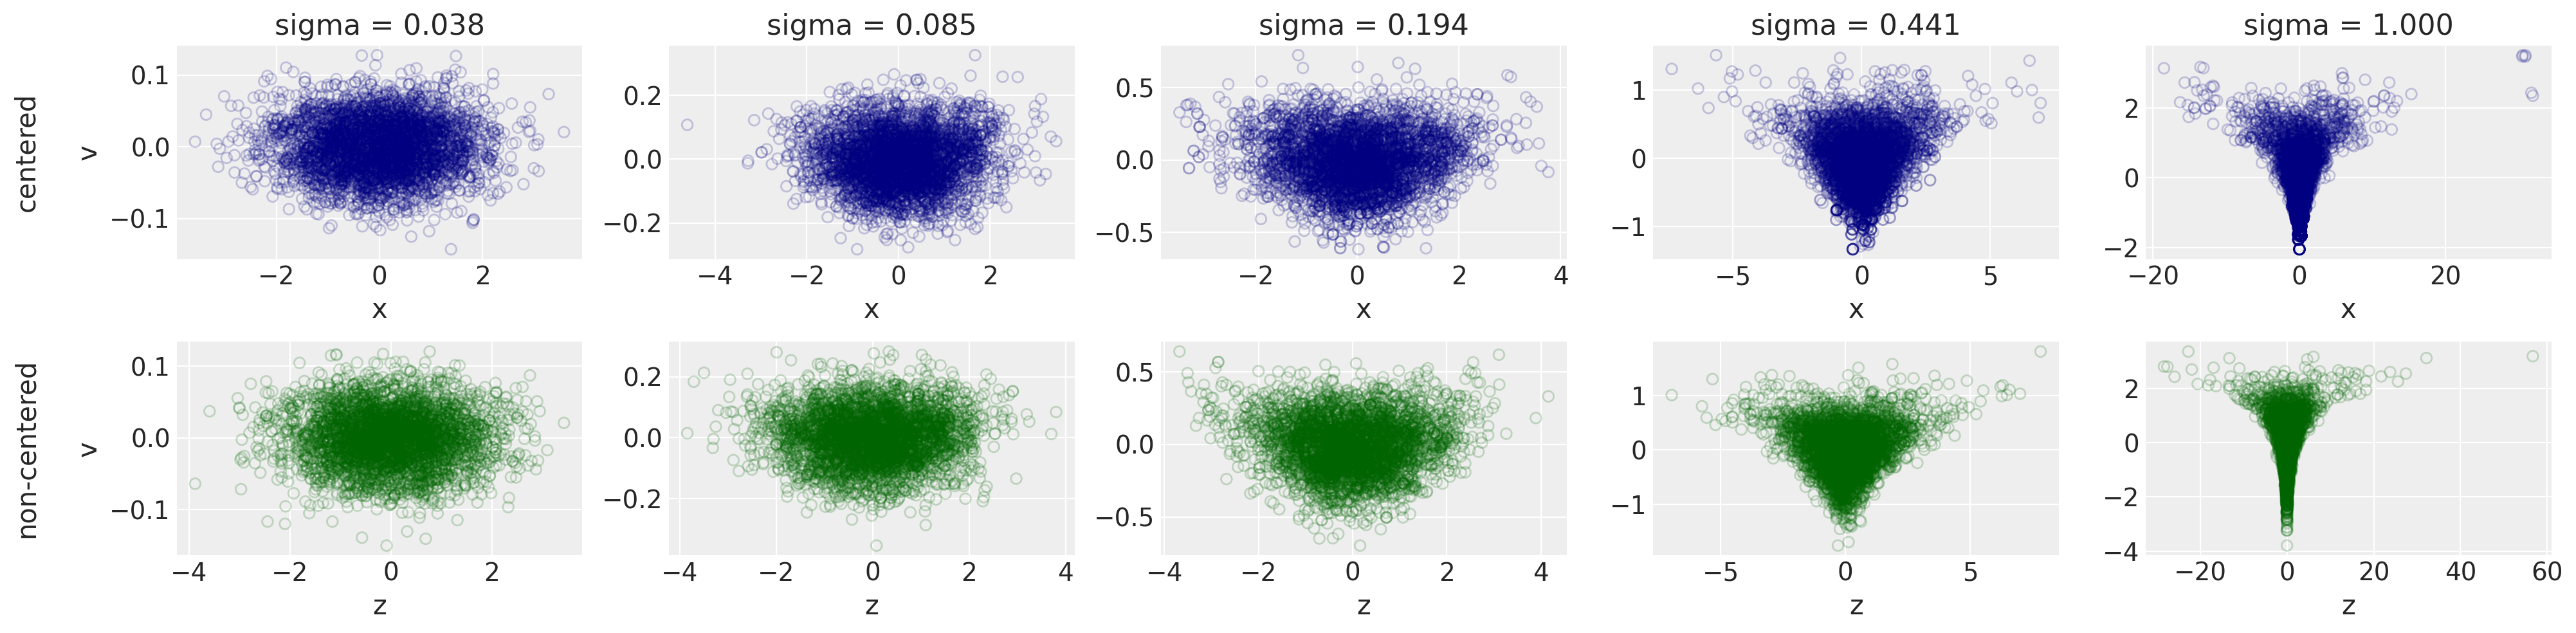

<IPython.core.display.Javascript object>

In [748]:
f, axes = plt.subplots(2, int(len(sigmas)/2), figsize=(20, 5))

for sigma, ax in zip(sigmas[1:len(sigmas):2], axes.flat):

    samples_C = pm.trace_to_dataframe(traces_C[sigma])
    ax.scatter(samples_C['x'], samples_C['v'], alpha=0.2, facecolors='none', edgecolors='navy')
    # number of divergences don't seem to match plot
    # bool_div_c = trace_mC['diverging']
    # ax.scatter(samples_C.loc[bool_div_c, 'x'], samples_C.loc[bool_div_c, 'v'], alpha=0.2, facecolors='red', s=2**2)

    sigma_str = '{:.3f}'.format(sigma)
    ax.set_title(f'sigma = {sigma_str}')
    ax.set_xlabel('x')
    if ax.is_first_col() & ax.is_first_row():
        ax.set_ylabel('centered\n\nv')

for sigma, ax in zip(sigmas[1:len(sigmas):2], axes.flat[int(len(sigmas)/2):len(sigmas)]):
    samples_NC = pm.trace_to_dataframe(traces_NC[sigma])
    #ax.scatter(samples_NC['z'], samples_NC['v'], alpha=0.2, facecolors='none', edgecolors='darkgreen')
    ax.scatter(samples_NC['x'], samples_NC['v'], alpha=0.2, facecolors='none', edgecolors='darkgreen')
    # bool_div_nc = trace_mNC['diverging']
    # ax.scatter(samples_NC.loc[bool_div_nc, 'z'], samples_NC.loc[bool_div_nc, 'v'], alpha=0.2, facecolors='red', s=2**2)

    ax.set_xlabel('z')
    if ax.is_first_col() & ax.is_last_row():
        ax.set_ylabel('non-centered\n\nv')
        
plt.tight_layout()

## Number of divergences

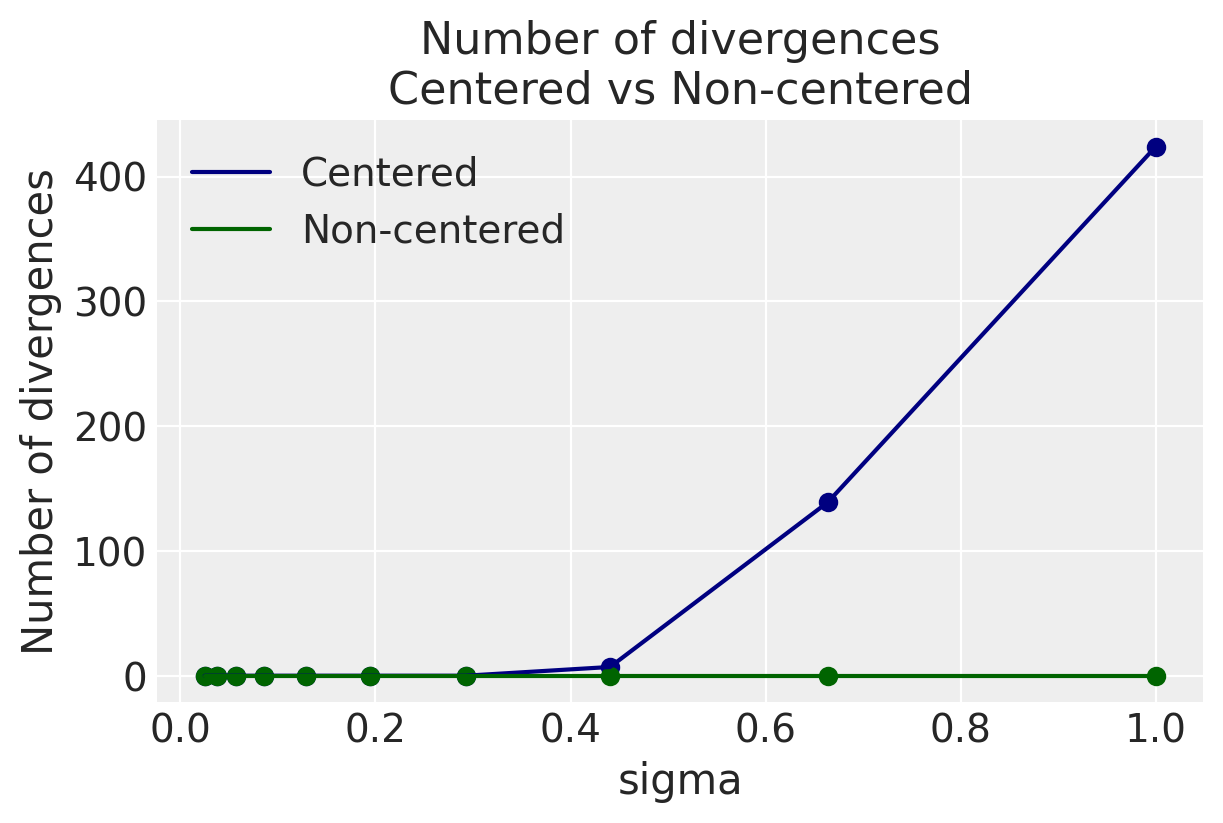

<IPython.core.display.Javascript object>

In [749]:
f, ax1 = plt.subplots(figsize=(6, 4))
ax1.scatter(div_C.keys(), div_C.values(), color='navy')
ax1.plot(div_C.keys(), div_C.values(), color='navy', label='Centered')
ax1.scatter(div_NC.keys(), div_NC.values(), color='darkgreen')
ax1.plot(div_NC.keys(), div_NC.values(), color='darkgreen', label='Non-centered')
ax1.set(xlabel='sigma', ylabel='Number of divergences', title='Number of divergences\nCentered vs Non-centered')
ax1.legend()

## Number of effective samples and R-hat

In [750]:
# Put the summary results in one table to facilitate plotting
df_summary_C = pd.concat(pd.DataFrame(summary_C[sigma]).reset_index().rename(columns={'index': 'var'}) for sigma in sigmas).reset_index(drop=True)
df_summary_C['sigma'] = sorted(list(sigmas)*2)

df_summary_NC = pd.concat(pd.DataFrame(summary_NC[sigma]).reset_index().rename(columns={'index': 'var'}) for sigma in sigmas).reset_index(drop=True)
df_summary_NC['sigma'] = sorted(list(sigmas)*3)

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'sigma'),
 Text(0, 0.5, 'R-hat'),
 None,
 Text(0.5, 1.0, 'R-hat for x')]

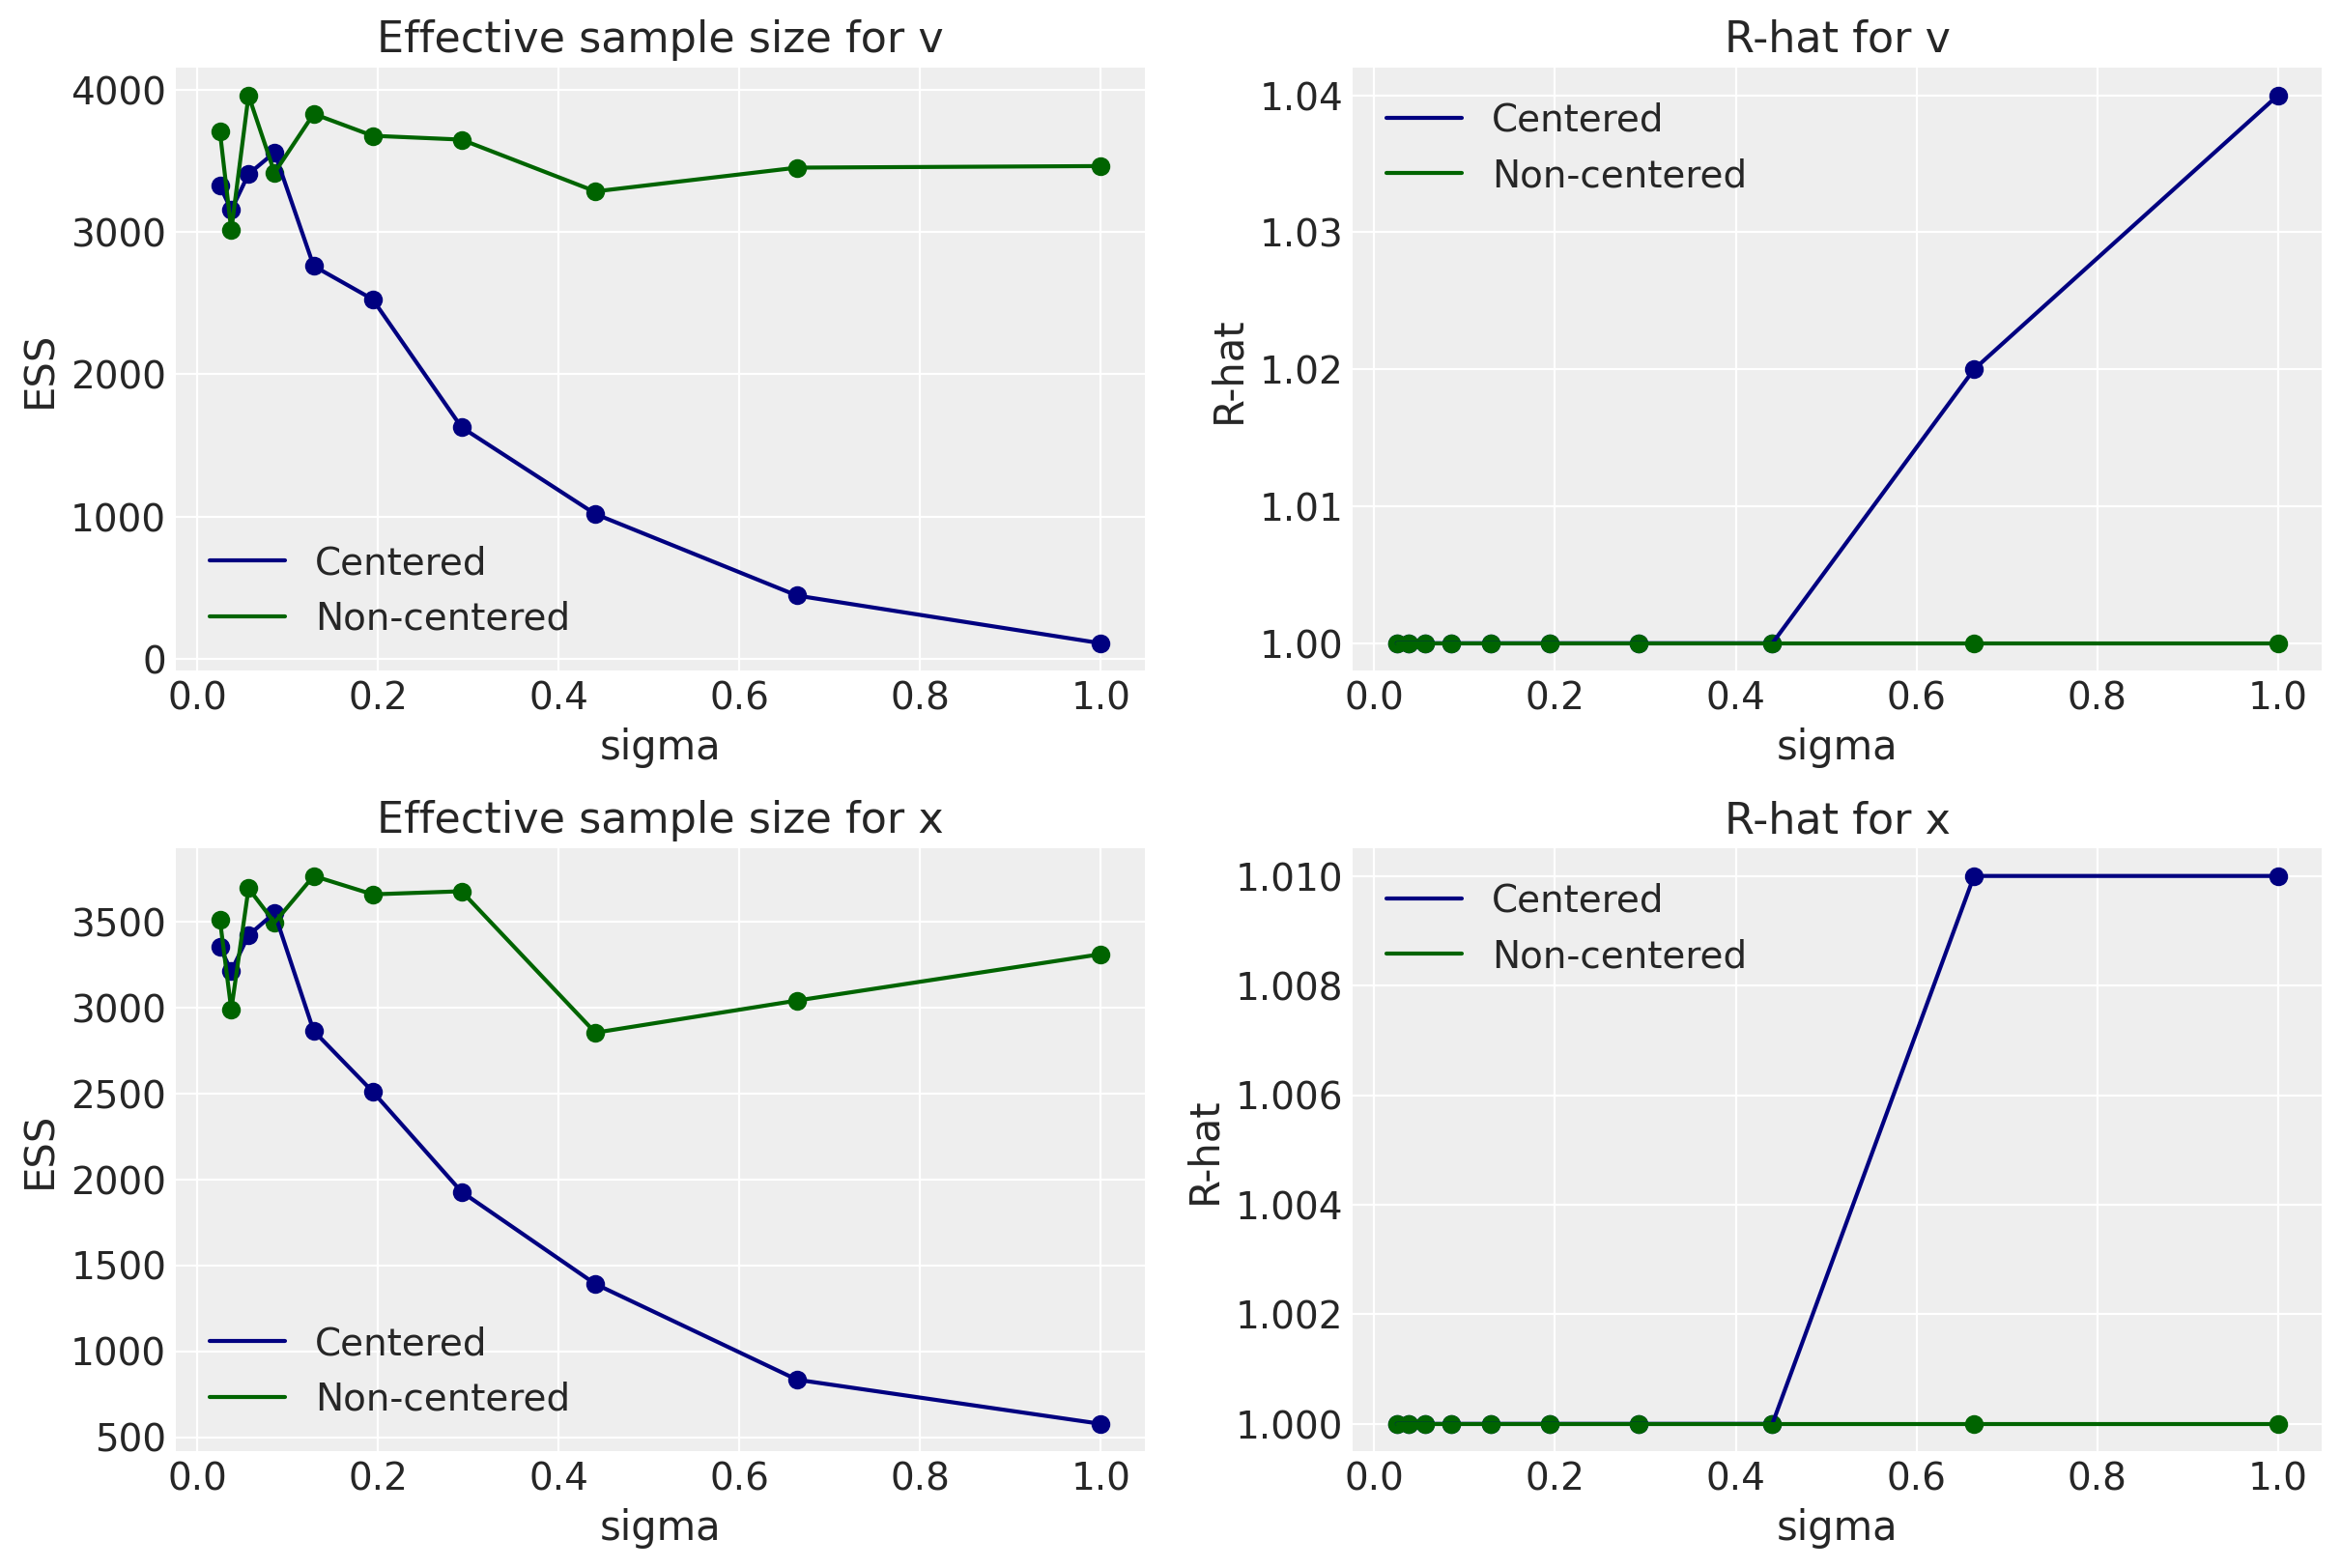

<IPython.core.display.Javascript object>

In [751]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Top row (v) ---------

# plot centered ESS
df_centered_v = df_summary_C.loc[df_summary_C['var']=='v', :]
ax1.scatter(df_centered_v['sigma'], df_centered_v['ess_mean'], color='navy')
ax1.plot(df_centered_v['sigma'], df_centered_v['ess_mean'], color='navy', label='Centered')

ax2.scatter(df_centered_v['sigma'], df_centered_v['r_hat'], color='navy')
ax2.plot(df_centered_v['sigma'], df_centered_v['r_hat'], color='navy', label='Centered')

# plot non-centered ESS
df_noncentered_v = df_summary_NC.loc[df_summary_NC['var']=='v', :]
ax1.scatter(df_noncentered_v['sigma'], df_noncentered_v['ess_mean'], color='darkgreen')
ax1.plot(df_noncentered_v['sigma'], df_noncentered_v['ess_mean'], color='darkgreen', label='Non-centered')

ax2.scatter(df_noncentered_v['sigma'], df_noncentered_v['r_hat'], color='darkgreen')
ax2.plot(df_noncentered_v['sigma'], df_noncentered_v['r_hat'], color='darkgreen', label='Non-centered')

# plot decorations
ax1.legend()
ax1.set(xlabel='sigma', ylabel='ESS', xscale='linear', title='Effective sample size for v')

ax2.legend()
ax2.set(xlabel='sigma', ylabel='R-hat', xscale='linear', title='R-hat for v')

# Bottom row (x) ---------

# plot centered ESS
df_centered_x = df_summary_C.loc[df_summary_C['var']=='x', :]
ax3.scatter(df_centered_x['sigma'], df_centered_x['ess_mean'], color='navy')
ax3.plot(df_centered_x['sigma'], df_centered_x['ess_mean'], color='navy', label='Centered')

ax4.scatter(df_centered_x['sigma'], df_centered_x['r_hat'], color='navy')
ax4.plot(df_centered_x['sigma'], df_centered_x['r_hat'], color='navy', label='Centered')

# plot non-centered ESS
df_noncentered_x = df_summary_NC.loc[df_summary_NC['var']=='x', :]
ax3.scatter(df_noncentered_x['sigma'], df_noncentered_x['ess_mean'], color='darkgreen')
ax3.plot(df_noncentered_x['sigma'], df_noncentered_x['ess_mean'], color='darkgreen', label='Non-centered')

ax4.scatter(df_noncentered_x['sigma'], df_noncentered_x['r_hat'], color='darkgreen')
ax4.plot(df_noncentered_x['sigma'], df_noncentered_x['r_hat'], color='darkgreen', label='Non-centered')

# plot decorations
ax3.legend()
ax3.set(xlabel='sigma', ylabel='ESS', xscale='linear', title='Effective sample size for x')

ax4.legend()
ax4.set(xlabel='sigma', ylabel='R-hat', xscale='linear', title='R-hat for x')



When looking at the number of divergences, effective sample size, and R-hat, smaller values of sigma result in good sampling whether it's in the centered or non-centered form of the Devil's Funnel equations. However, between 0.2 and 0.4, we begin to see indications that the non-centered form is clearly doing better.

# Conclusion

If the biggest trick the devil pulled was convincing the world he didn't exist, then perhaps in this case the devil's funnel's trick was thinking that I could reason my way through understanding when centered and non-centered parameterizations would be better.

Appendix: Environment and system parameters

In [736]:
%watermark -n -u -v -iv -w

Last updated: Wed Feb 23 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

seaborn    : 0.11.1
matplotlib : 3.3.4
statsmodels: 0.12.2
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pandas     : 1.2.1
arviz      : 0.11.1
numpy      : 1.20.1
pymc3      : 3.11.0
scipy      : 1.6.0
daft       : 0.1.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>